# Analysis of Austin's BCycle Bike Share Program
## About Austin BCycle
  Austin BCycle is a city-owned, non-profit bike share program established in 2013. Users can pay to checkout bikes via subscription passes or pay-as-you-ride for short trips in Austin.

  The datasets are publicly available via Austin's government website: [Austin BCycle Trips](https://data.austintexas.gov/Transportation-and-Mobility/Austin-B-Cycle-Trips/tyfh-5r8s) and [Austin BCycle Kiosks](https://data.austintexas.gov/Transportation-and-Mobility/Austin-B-Cycle-Kiosk-Locations/qd73-bsdg/data)


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, chisquare
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import calendar
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot
from IPython.display import display
import requests

%matplotlib inline

# Import kiosk data
kiosk = pd.read_csv("Austin_B-Cycle_Kiosk_Locations.csv")

# Import trip data
trips = pd.read_csv("Austin_B-Cycle_Trips.csv")

print(kiosk.dtypes)
print(kiosk.shape)
print(trips.dtypes)
print(trips.shape)

Kiosk ID          int64
Kiosk Name       object
Kiosk Status     object
Latitude        float64
Longitude       float64
Location         object
dtype: object
(96, 6)
Trip ID                    int64
Membership Type           object
Bicycle ID                object
Checkout Date             object
Checkout Time             object
Checkout Kiosk ID        float64
Checkout Kiosk            object
Return Kiosk ID           object
Return Kiosk              object
Trip Duration Minutes      int64
Month                    float64
Year                     float64
dtype: object
(1216805, 12)


## Data Cleaning
The kiosk dataframe requires minimal processing.

In [4]:
# Drop redundant 'Location' column
kiosk = kiosk.drop(columns='Location')

# Dummy code kiosk status column
kiosk = pd.get_dummies(kiosk, columns= ['Kiosk Status'])

# Drop redundant status column
kiosk = kiosk.drop(columns='Kiosk Status_closed')   

# Rename 'kiosk status' to 'active' and format other column names
kiosk.columns = ['id', 'kiosk_name', 'lat', 'long', 'active']

print('kiosk NA values:\n',kiosk.isna().sum())

KeyError: "['Location'] not found in axis"

The trips data, however, requires significant cleaning. We will format the column names, and change columns to the proper data type. We will also take this opportunity to extract the hour and day of the week variable from 'checkout_time'.

In [7]:
# Format column names
trips.columns = ['trip_id','membership_type','bicycle_id','checkout_date','checkout_time','checkout_kiosk_id','checkout_kiosk','return_kiosk_id','return_kiosk','trip_minutes','month','year']

# Change columns to proper dtype
print(trips.dtypes)

# Convert time to datetime and add hour column
trips['checkout_time'] = pd.to_datetime(trips['checkout_time'], format='%H:%M:%S').dt.time
trips['hour'] = [x.hour for x in trips['checkout_time']]

# Format the checkout_date column 
trips['checkout_date'] = pd.to_datetime(trips['checkout_date'], format='%m/%d/%Y')

# Remove commas from year column
#trips['year'] = trips['year'].str.replace(',', '')

# Add day of the week column
trips['day_of_week'] = trips['checkout_date'].dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})

print('Number of Missing Values:\n\n', trips.isna().sum())

ValueError: Length mismatch: Expected axis has 14 elements, new values have 12 elements

We can fill the missing values for 'membership_type' and 'bicycle_id' with "unknown". We can extract missing values for month and year from 'checkout_date'. For now we will fill in the missing values for 'checkout_kiosk_id' and 'return_kiosk_id' with 0.  

In [10]:
# Fill NA with 'unknown' for membership_type and bicycle_id
trips['membership_type'] = trips['membership_type'].fillna('unknown')
trips['bicycle_id'] = trips['bicycle_id'].fillna('unknown')



# Extract info from checkout_date to fill NA's for month and year
trips['month'] = trips['month'].fillna(trips['checkout_date'].dt.month).astype(int)
trips['year'] = trips['year'].fillna(trips['checkout_date'].dt.year).astype(int)

# Clean kiosk ids and convert to integers for both checkout_kiosk_id and return_kiosk_id
for id in ['checkout_kiosk_id','return_kiosk_id']:
    trips[id] = pd.to_numeric(trips[id], errors='coerce')    # Resolves any non-numeric entries
    trips[id] = trips[id].fillna(0)                          # Replace NA's with 0 
    trips[id] = trips[id].astype('int64')

We need to format the 'checkout_kiosk' and 'return_kiosk' columns. Between both columns we see 195 unique entries, due to multiple entry formats of the same kiosks. 

In [12]:
# Inspect the kiosks
print('Number of unique kiosks from trips dataframe:',len(pd.unique(trips[['checkout_kiosk', 'return_kiosk']].values.ravel('K'))))
print('Number of unique kiosks from kiosk dataframe:',len(kiosk))              
print("Example of duplicate entries:",trips[trips['checkout_kiosk_id']==3798]['checkout_kiosk'].unique())

Number of unique kiosks from trips dataframe: 111
Number of unique kiosks from kiosk dataframe: 96
Example of duplicate entries: ['21st & Speedway @PCL']


We will implement some string parsing to make the entries uniform by copying in the kiosk names used in the kiosk dataframe.

In [14]:
# Select just the id and kiosk name from kiosk df for a clean merge
kiosk_ids = kiosk[['id', 'kiosk_name']]

# Merge with the trips df by kiosk id
checkout_kiosks_merged = trips.merge(kiosk_ids, how='left', left_on='checkout_kiosk_id', right_on='id')
return_kiosks_merged = trips.merge(kiosk_ids, how='left', left_on='return_kiosk_id', right_on='id')

# Some of our trips kiosk id's are 0 (unknown) so they won't have a matching counterpart from the kiosk df, resulting in an NA value
# We will fill those NAs with the kiosk name already provided by the trips df and then copy the kiosk data into the trips df
trips['checkout_kiosk'] = checkout_kiosks_merged['kiosk_name'].fillna(trips['checkout_kiosk'])
trips['return_kiosk'] = return_kiosks_merged['kiosk_name'].fillna(trips['return_kiosk'])

# The kiosks that didn't have an id to match will need to be adjusted manually
# We can also use this opportunity to consolidate other entries

# Function that updates kiosk name and id for checkout and return kiosks
def update_kiosk_info(old_name, new_name):
    '''
    Function changes the kiosk name for checkout_kiosk and return_kiosk in trips df. Also updates kiosk_id to correct number in the kiosk df (if available)
    '''
    for k in ['checkout_kiosk','return_kiosk']:
        trips[k] = trips[k].str.replace(old_name, new_name)              # Replace the old name to match other occurences
        if kiosk['kiosk_name'].isin([new_name]).any():
            correct_id = kiosk[kiosk['kiosk_name'] == new_name]['id'].values[0]                # Locate the correct kiosk_id if available
            trips.loc[trips[k] == new_name, k + '_id'] = trips.loc[trips[k] == new_name, k + '_id'].replace(0, correct_id)  # Replace 0 kiosk_id with id referenced from kiosk df

# Format the remaining strings 
update_kiosk_info('ACC - West & 12th', 'ACC - West & 12th Street')
update_kiosk_info('Zilker Park at Barton Springs & William Barton Drive', 'Zilker Park')
update_kiosk_info('Convention Center/ 3rd & Trinity', 'Convention Center / 3rd & Trinity')
update_kiosk_info('East 11th Street at Victory Grill', 'East 11th St. at Victory Grill')
update_kiosk_info(r'^Main Office$|^Repair Shop$|^Shop$|^Main Shop$|^Customer Service$|^Re-branding$', 'OFFICE/Main/Shop/Repair')
update_kiosk_info(r'^Missing$|^Stolen$','Missing or Stolen')

unique_kiosks = len(pd.unique(trips[['checkout_kiosk', 'return_kiosk']].values.ravel('K')))
print('Number of unique kiosks from trips dataframe:', unique_kiosks) 

Number of unique kiosks from trips dataframe: 102


We have successfully reduced the number of unique kiosks from 195 to 111. Note there are some temporary pop-up kiosks that are not included in the kiosk df. The dataset also contains many different membership types, several of which can be consolidated.

In [16]:
# Clean membership_type .
print(trips['membership_type'].unique())

# Consolidate "Single Trip" memberships
trips['membership_type'] = trips['membership_type'].replace({'U.T. Student Membership': 'UT Student Membership',
                                                            'Pay-as-you-ride': 'Single Trip',
                                                            'Single Trip (Pay-as-you-ride)': 'Single Trip',
                                                            'Single Trip Ride': 'Single Trip',
                                                            'Single Trip ': 'Single Trip'
                                                            })

['unknown' 'Walk Up' 'Local365' 'Local365+Guest Pass' 'Local30'
 'Weekender' 'Explorer' 'Founding Member' 'Annual Membership' 'Annual'
 'Local365 Youth with helmet (age 13-17 riders)' 'Annual Member'
 'Republic Rider (Annual)' 'Annual Pass' 'Annual Plus'
 'Try Before You Buy Special' 'Membership: pay once  one-year commitment'
 'Local365 ($80 plus tax)' 'Weekender ($15 plus tax)'
 'Denver B-cycle Founder' 'Republic Rider' '7-Day'
 'Local30 ($11 plus tax)' 'Explorer ($8 plus tax)' 'RideScout Single Ride'
 'PROHIBITED' 'RESTRICTED' 'Annual ' 'Local365 Youth (age 13-17 riders)'
 'UT Student Membership' 'Madtown Monthly' 'Annual Plus Membership'
 'Aluminum Access' 'HT Ram Membership' '3-Day Weekender'
 '24 Hour Walk Up Pass' '3-Day Explorer' '$1 Pay by Trip Fall Special'
 'Single Trip' 'ACL 2019 Pass' 'Local365- 1/2 off Anniversary Special'
 'Local365+Guest Pass- 1/2 off Anniversary Special'
 'Local365 Youth (age 13-17 riders)- 1/2 off Special'
 '$1 Pay by Trip Winter Special' 'Annual Memb

Now we need to check the data for outliers and suspicious entries. Since we are trying to capture user data, we can drop the entries with "OFFICE/Main/Shop/Repair" as the checkout_kiosk or return_kiosk, since it is likely that this was done by an employee. We also want to drop missing or stolen bikes, as obviously their trip length is unreliable. We will retain the missing or stolen data seperately to investigate later though.

In [18]:
# Drop rows containing 'OFFICE/Main/Shop/Repair'
trips = trips[(trips['checkout_kiosk'] != 'OFFICE/Main/Shop/Repair') & (trips['return_kiosk'] != 'OFFICE/Main/Shop/Repair')]

# Separate 'missing or stolen' bikes
missing_or_stolen = trips[(trips['checkout_kiosk'] == 'Missing or Stolen') | (trips['return_kiosk'] == 'Missing or Stolen')]
trips = trips.drop(missing_or_stolen.index)

Upon further inspection of the data, we notice that 10 digit trip_ids' entries in the checkout_time column are all in the format 'HH:12:SS' (all checkout_times are timestamped at 12 minutes after the hour), while the 7 or 8 digit trip_id's vary normally, which would appear to be some sort of error. The 10 digit trip_id's are phased out on 01/03/2016. We can only assume that trip length was derived from the checkout time, and therefore the trip lengths on the 10 digit trip_id entries are not reliable. We also notice that nearly 80% of bicycle_id NaN's are in this subset, which further indicates that the 10 digit trip_id data is unreliable. These entries will be omitted.

In [20]:
# locate all 10 digit trip_id's
bad_timestamps = trips[trips['trip_id'].astype(str).str.len() == 10]
print(bad_timestamps.head())

# Remove 10 digit trip_id's
trips = trips.drop(bad_timestamps.index)

Empty DataFrame
Columns: [trip_id, membership_type, bicycle_id, checkout_date, checkout_time, checkout_kiosk_id, checkout_kiosk, return_kiosk_id, return_kiosk, trip_minutes, month, year, hour, day_of_week]
Index: []


In [22]:
# Inspect for erroneous data
print(f"Minimum Trip Length: {trips['trip_minutes'].min()} minutes")
print(f"Maximum Trip Length: {trips['trip_minutes'].max()} minutes")
print(f"Median Trip Length: {trips['trip_minutes'].median():.1f} minutes")
print("Number of 0 minute trips: ", (trips['trip_minutes'] == 0).sum())

Minimum Trip Length: 0 minutes
Maximum Trip Length: 720 minutes
Median Trip Length: 11.0 minutes
Number of 0 minute trips:  12651


Now we want to check the validity of the trip lengths. There are many entries that are less than 5 minutes long and have the same checkout and return kiosk. While it is possible that users may make a trip of this nature for some reason, it seems far more likely that it is the result of an error while checking out the bike. We will separate these short 'round trips' from the dataframe to inspect later.

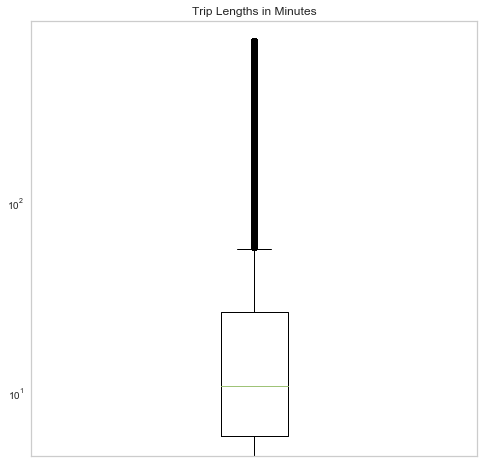

In [24]:
# Segregate round trips that are 5 minutes or less
short_round_trips = trips[(trips['trip_minutes'] <= 5) & (trips['checkout_kiosk'] == trips['return_kiosk'])]
trips = trips.drop(short_round_trips.index)

# Boxplot of trip length, log scale
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(trips['trip_minutes'])
ax.set_title("Trip Lengths in Minutes")
ax.set_yscale('log')
ax.set_xticklabels([])
ax.grid(False)
plt.show()

Now we will handle the excessively long trips. The boxplot shows a steady stream of suspicious outliers (the bold line), including one that is nearly 35,000 minutes long. A 24 day long bike trip is clearly erroneous, but it becomes less obvious which trips are valid as the trip length decreases. We can't confidently remove all outliers, we expect that plenty of these outliers are valid. 

We know that the median trip length is 12 minutes, bike use is charged by the minute for non pass holders, and pass holders have to pay extra for trips beyond 60 minutes, and there is widespread kiosk coverage. These are strong incentives to keep trips short. We also know that plenty of erroneous data exist, including many trips that are thousands of minutes long. Many users report that the kiosks were not allowing them to return bikes, which may have kept the clock running. Other users were simply unaware of the pricing policies and racked up more usage than they anticipated. We will need to find a good balance of retaining natural outliers while removing as much faulty data as possible. 12 hours seems like the reasonable maximum amount of time anybody should use a rental bicycle.

In [26]:
# print value counts of trip_minutes
print(trips['trip_minutes'].value_counts(bins=20).sort_index().to_frame().reset_index().rename(columns={'index': 'trip_minutes', 'trip_minutes': 'count'}))

# add trips over 12hrs to the long_trips df
long_trips = trips[trips['trip_minutes'] > 720]

# reduce trips dataframe to trips less than 12hrs minutes
trips = trips.drop(long_trips.index)

trip_minutes   count
0   (-0.721, 36.0]  675645
1     (36.0, 72.0]  104807
2    (72.0, 108.0]   22750
3   (108.0, 144.0]   10340
4   (144.0, 180.0]    5046
5   (180.0, 216.0]    2351
6   (216.0, 252.0]    1519
7   (252.0, 288.0]     897
8   (288.0, 324.0]     642
9   (324.0, 360.0]     509
10  (360.0, 396.0]     468
11  (396.0, 432.0]     472
12  (432.0, 468.0]     422
13  (468.0, 504.0]     432
14  (504.0, 540.0]     395
15  (540.0, 576.0]     363
16  (576.0, 612.0]     373
17  (612.0, 648.0]     334
18  (648.0, 684.0]     356
19  (684.0, 720.0]     283


## Data Exploration
Now that our data is in the proper format, and erroneous data removed, we can inspect it visually to get better acquainted.


In [28]:
# Time range of data
print("Range of Data\n", trips['checkout_date'].dt.date.min(), "through", trips['checkout_date'].dt.date.max())

# Average trip length
print(f"\nAverage Length of Trip: {trips['trip_minutes'].mean():.1f} minutes\n")

# Median trip length
print(f"\Median Length of Trip: {trips['trip_minutes'].median():.1f} minutes\n")

# Calculate the number of years riders have collectively spent on bikes
def minutes_to_years(minutes):
    years = int(minutes / 525600)
    remaining_minutes = minutes - years * 525600

    days = int(remaining_minutes / 1440)
    remaining_minutes = remaining_minutes - days * 1440

    hours = int(remaining_minutes / 60)
    remaining_minutes = remaining_minutes - hours * 60

    print(f"Amount of time Austin B-Cycles users have collectively spent on bikes since inception: {years} years {days} days {hours} hrs {remaining_minutes:.0f} min\n")

minutes_to_years(trips['trip_minutes'].sum())

Range of Data
 2016-01-01 through 2019-11-30

Average Length of Trip: 25.0 minutes

\Median Length of Trip: 11.0 minutes

Amount of time Austin B-Cycles users have collectively spent on bikes since inception: 39 years 149 days 20 hrs 32 min



In [ ]:
# Plot the top memberships
top_10_memberships = (trips['membership_type'].value_counts(normalize=True).sort_values(ascending=False)*100).head(10)

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(top_10_memberships.index, top_10_memberships)

ax.set_title("Top 10 Membership Types as Percentage of Total Trips")
ax.tick_params(axis=u'both', which=u'both',length=0)
for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.yaxis.grid(False)
plt.show()

We see that UT Student, Walk Up, and Local365 members take the most trips.

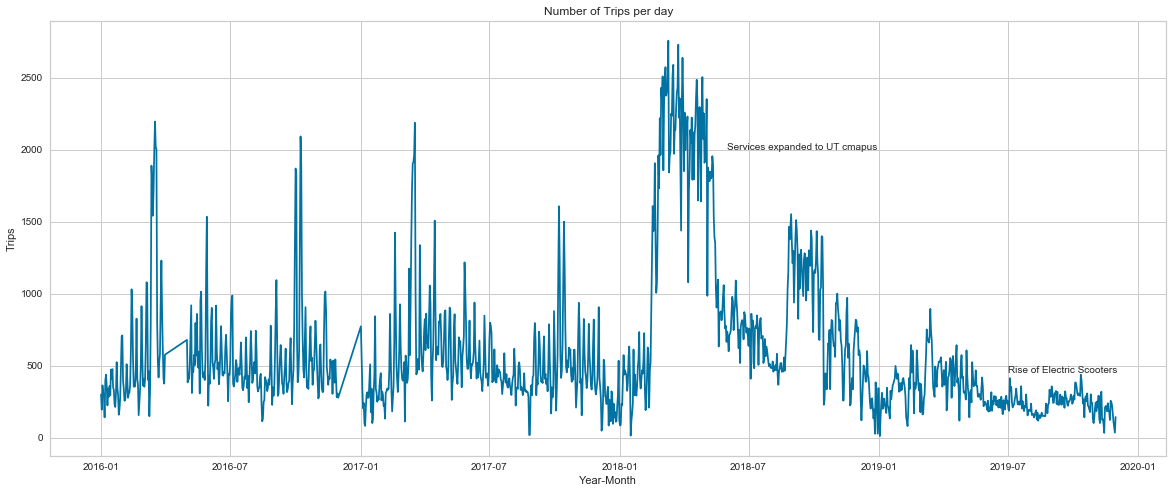

In [32]:
# Create a time series plot of trips per day
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(trips.groupby(['checkout_date']).size())
ax.set_title('Number of Trips per day')
ax.annotate('Rise of Electric Scooters', (date(2019, 7, 1), 450))
ax.annotate('Services expanded to UT cmapus', (date(2018, 6, 1), 2000))
ax.set_xlabel('Year-Month')
ax.set_ylabel('Trips')
plt.show()



  This plot reveals some interesting trends. One noticeable takeaway from this time series is the absence of data for April 2016 and December 2016. Missing data for the historically high traffic month of April will lead to an artificially deflated yearly total for 2016. Aside from that we see the seasonal nature of BCycle rentals. We also notice that 2018 saw a huge influx of BCyclye use but 2019 dropped off significantly. 

  After some research we see that the kiosks didn't expand into the UT campus until early 2018, at which point it had immediate success. The traffic continued to decline after the explosive launch, however. We can see this in the plot below. Our research indicates that the influx of electric scooters into the city is the likely culprit of the decrease in traffic in 2019. Users likely find them more convenient to use since there is no need to locate a kiosk.

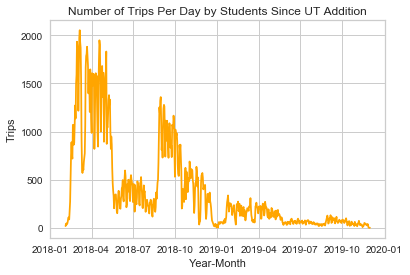

In [33]:
# Plot traffic to show inception of UT Student Membership
ut_students = trips[trips['membership_type'] == 'UT Student Membership'].groupby('checkout_date').size()
fig, ax = plt.subplots()
ax.plot(ut_students, color='orange')
ax.set_title('Number of Trips Per Day by Students Since UT Addition')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Trips')
plt.show()

We already saw that UT Student memberships were the most popular membership type, but we did not see (until now) that student membership didn't become available until 2018, at which point it became a huge success. If we compare the membership distributions again, this time filtered for dates since the UT student membership inception, we will see that the student memberships are much more dominant than the original bar plot shows.

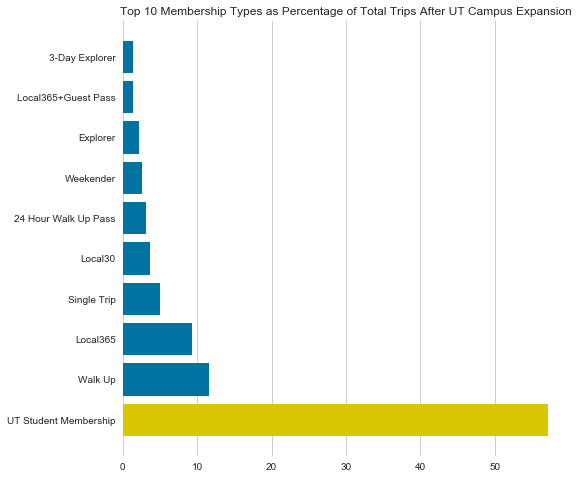

In [49]:
# Plot the top memberships for 2018 and beyond
# Find the first use of the UT Student Membership 
UT_member_start_date = trips[trips['membership_type'] == 'UT Student Membership'].sort_values('checkout_date')['checkout_date'].iloc[0].date()

# Filter data for trips since UT membership inception
top_10_memberships = (trips[trips['checkout_date'] >= UT_member_start_date]['membership_type'].value_counts(normalize=True).sort_values(ascending=False)*100).head(10)

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(top_10_memberships.index, top_10_memberships, color = 'ybbbbbbbbb')

ax.set_title("Top 10 Membership Types as Percentage of Total Trips After UT Campus Expansion")
ax.tick_params(axis=u'both', which=u'both',length=0)
for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.yaxis.grid(False)
plt.show()

Now it is clear to see the impact that the UT Student Membership has had on the program. Given that we now know that UT students are the major driving force behind trips taken, let's take a look at how the school schedule affects BCycle use.

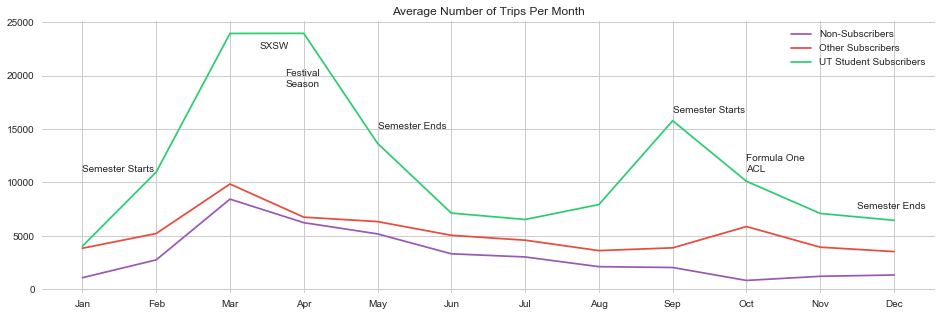

In [145]:
# Plot average number of trips by month
# Filter trips for trips since UT expansion
trips_since_UT = trips[trips['checkout_date'] >= UT_member_start_date]

# seperate membership types
walk_ups = trips_since_UT[trips_since_UT['membership_type'].isin(['Walk Up','Single Trip'])]
subscribers = trips_since_UT[~trips_since_UT['membership_type'].isin(['Walk Up','Single Trip', 'UT Student Membership'])]
students = trips_since_UT[trips_since_UT['membership_type']=='UT Student Membership']

# get results for each month
walk_ups_avg_trips_by_month = walk_ups.groupby(['year','month']).size().groupby('month').mean()
subscribers_avg_trips_by_month = subscribers.groupby(['year','month']).size().groupby('month').mean()
students_avg_trips_by_month = students.groupby(['year','month']).size().groupby('month').mean()

# plot
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ind = np.arange(1, 13)
ax.plot(ind, walk_ups_avg_trips_by_month, color="#9b59b6", label='Non-Subscribers')
ax.plot(ind, subscribers_avg_trips_by_month, color="#e74c3c", label='Other Subscribers')
ax.plot(ind, students_avg_trips_by_month, color="#2ecc71", label='UT Student Subscribers')

ax.annotate("ACL", (10, 11000))
ax.annotate("Formula One", (10, 12000))
ax.annotate("SXSW", (3.4, 22500))
ax.annotate("Festival", (3.75, 20000))
ax.annotate("Season", (3.75, 19000))
ax.annotate("Semester Starts", (9, 16500))
ax.annotate("Semester Ends", (5, 15000))
ax.annotate("Semester Starts", (1, 11000))
ax.annotate("Semester Ends", (11.5, 7500))

ax.set_title("Average Number of Trips Per Month")
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',])
ax.legend()
for key, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

Here we see the cyclical nature of number of trips taken, aggregated by membership type. While Non-Subscribers and Other Subscribers useage show similar trends, the usage of students swings violently. Student useage starts off low during the winter break, picks up as Spring classes start, and rides high through the Austin festival season. It dies down in mid May and eventually picks up again for Fall classes. While BCycle use clearly drops when class is out of session, there is some collineariety with the off putting summer and winter weather. Still, B-Cycles may benefit from running some summer and winter promotions to capture back some of that lost demand. We can also plot how demand shapes out during the course of the week.

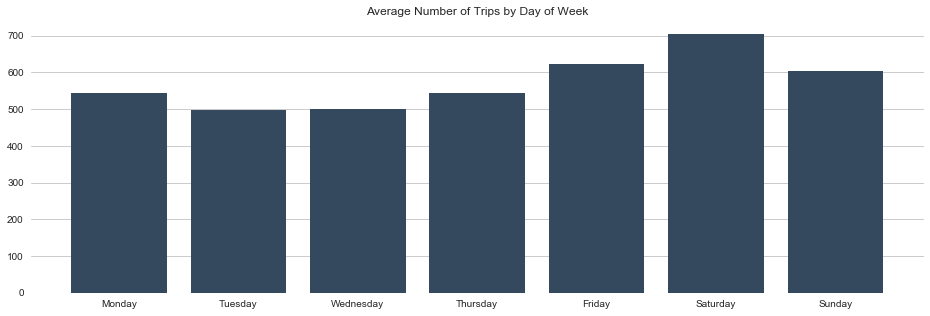

In [146]:
# Plot average number of trips by day

# Create a temporary dataframe storing all of the day_of_week's that existed during time period of the dataset
# Generator that takes a start date and end date as input and returns a list of all dates in between
def date_generator(date1, date2):     
    for n in range(int((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
all_dates = []
start = trips['checkout_date'].dt.date.min()  
end = trips['checkout_date'].dt.date.max()

for dt in date_generator(start, end):
    all_dates.append(dt)

temp_date_df = pd.DataFrame({'all_dates': all_dates})
temp_date_df['all_dates'] = pd.to_datetime(temp_date_df['all_dates'])

temp_date_df['day_of_week'] = temp_date_df['all_dates'].dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})

# Divide total trips for each day_of_week by the total number of day_of_week's to find the average use
trips_per_day_of_week = trips['day_of_week'].value_counts() / temp_date_df['day_of_week'].value_counts()

# Reorder days chronologically 
trips_per_day_of_week = trips_per_day_of_week.reindex(index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

# Plot
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
ax.bar(trips_per_day_of_week.index, trips_per_day_of_week, color="#34495e")
ax.xaxis.grid(False)
ax.set_title("Average Number of Trips by Day of Week")
ax.tick_params(axis=u'both', which=u'both',length=0)
for key, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

The heaviest bike use occurs on Fridays, Saturdays, and Sundays, though, not by a huge margin. 

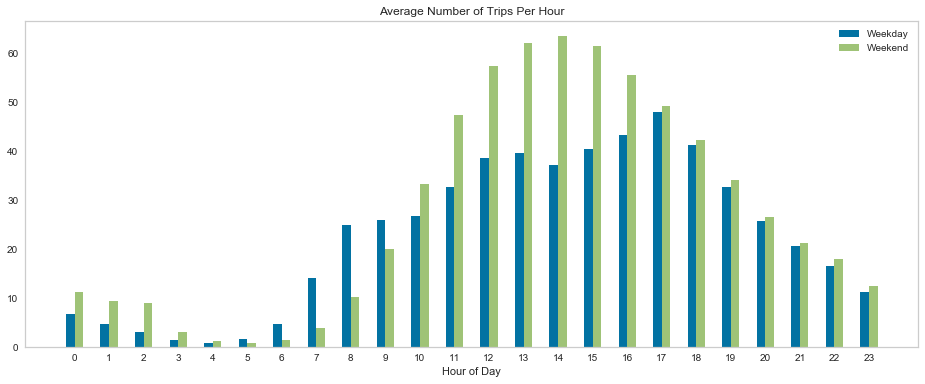

In [147]:
# Plot Average number of trips by time of day
# Find total number of hours during time period (needed to find the average per hour)

# create a data frame with a list of all 24 hours for each date
temp_date_df['hour'] = [range(24) for x in range(len(temp_date_df))]

# create function that expands the list of hours into individual rows
def expand_row(df):
    lens = [len(item) for item in df['hour']]
    return pd.DataFrame( {"all_dates" : np.repeat(df['all_dates'].values, lens),
                          "day_of_week" : np.repeat(df['day_of_week'].values, lens),
                          "hour" : np.concatenate(df['hour'].values)})

temp_hours_df = expand_row(temp_date_df)

# find the number of occurences for each hour for all weekends
total_weekend_hours = temp_hours_df[temp_hours_df['day_of_week'].isin(['Saturday','Sunday'])]
total_weekend_hours = total_weekend_hours.groupby('hour').size()

# find the number of occurences for each hour for all weekdays
total_weekday_hours = temp_hours_df[~temp_hours_df['day_of_week'].isin(['Saturday','Sunday'])]
total_weekday_hours = total_weekday_hours.groupby('hour').size()

# find the sum of all trips that occurred for each hour for weekends
weekend_trips_by_hour = trips[trips['day_of_week'].isin(['Saturday','Sunday'])].groupby('hour').size()

# find the sum of all trips that occurred for each hour for weekdays
weekday_trips_by_hour = trips[~trips['day_of_week'].isin(['Saturday','Sunday'])].groupby('hour').size()

# find the average number of trips for each hour of the day
weekend_avg_per_hour = weekend_trips_by_hour / total_weekend_hours
weekday_avg_per_hour = weekday_trips_by_hour / total_weekday_hours

fig, ax = plt.subplots(figsize=(16, 6))
ind = combined_trips_per_hour.index
width = .25

bar1 = ax.bar(ind - width / 2, combined_trips_per_hour['weekday_trips_per_hour'], width)
bar2 = ax.bar(ind + width / 2, combined_trips_per_hour['weekend_trips_per_hour'], width)

ax.set_xticks(range(24))
ax.grid(False)
ax.set_title('Average Number of Trips Per Hour')
ax.set_xlabel("Hour of Day")
ax.legend((bar1, bar2), ('Weekday', 'Weekend'))
plt.show()


This plot divides trips into weekday and weekend use. Weekdays get a lot more bike traffic in the early morning, likely students and commuters, while use is heaviest on weekend afternoons.<br><br>
Now that we have a broad overview of the data, we can inspect more closely. First we will address these excessively long trips (ranging from 720 minutes to 34,238 minutes) to see if there are any correlations between these trips and the checkout kiosk, indicating that there may be a problem with the kiosk or how users interact with that kiosk. We will focus on the top 10 kiosks by amount of trips.


In [148]:
# Let's look into Missing/Stolen Bicycles to see if we can reduce loss

print('Number of Stolen or Missing Bikes: ', len(missing_or_stolen))
print('\nPercent of trips that result in a Stolen or Missing bike: ', round(len(missing_or_stolen) / len(trips) * 100, 3))
print('\n', missing_or_stolen['membership_type'].value_counts())
print('\nAverage Trip Length: {:.1f} minutes'.format(missing_or_stolen['trip_minutes'].mean()))


Number of Stolen or Missing Bikes:  48

Percent of trips that result in a Stolen or Missing bike:  0.006

 Walk Up                           38
UT Student Membership              3
Local365                           2
Weekender                          1
Local30                            1
Explorer                           1
24-Hour Kiosk (Austin B-cycle)     1
Founding Member                    1
Name: membership_type, dtype: int64

Average Trip Length: 3836.4 minutes


Only 48 trips (or 0.006%) report as Missing or Stolen, which is a very tidy loss rate. The vast majority of these trips are Walk Up users, which would make sense whether the user's intent is malicious or the user is more prone to user error. Of course we also see their very long trip lengths, since these bikes were not recovered. 

Which bikes are due to be retired?

In [149]:
# Print list of bicycle_id's that have had over 30,000 minutes of use
bikes_by_total_minutes = trips.groupby('bicycle_id')['trip_minutes'].sum().sort_values(ascending=False)
bikes_over_30k_minutes = bikes_by_total_minutes[bikes_by_total_minutes > 30000]
print('Total Use in Minutes\n')
print(bikes_over_30k_minutes)

Total Use in Minutes

bicycle_id
507.0    44122
862.0    41552
860.0    40346
751.0    40084
709.0    40037
728.0    39364
135.0    39206
472.0    39007
166.0    38811
969.0    38603
451.0    38567
871.0    38442
460.0    38406
863.0    38266
866.0    38034
277.0    37859
693.0    37634
160.0    37516
749.0    37383
775.0    37365
382.0    37146
563.0    36870
124.0    36664
465.0    36621
86.0     36523
924.0    36511
610.0    36460
571.0    36338
411.0    36326
872.0    36177
         ...  
385.0    30734
975.0    30729
384.0    30727
696.0    30725
712.0    30725
561.0    30718
414.0    30713
219.0    30690
321.0    30677
884.0    30664
979.0    30640
970.0    30630
40.0     30604
963.0    30596
207.0    30585
647.0    30537
263.0    30512
214.0    30500
104.0    30475
877.0    30403
998.0    30328
209.0    30314
49.0     30290
327.0    30269
878.0    30257
398.0    30161
765.0    30157
110.0    30123
183.0    30069
266.0    30063
Name: trip_minutes, Length: 207, dtype: int64


Is there evidence that users mistakenly take long trips, under the impression that they have unlimited use? B-Cycles rules state that 24hr pass users will be charged for trips longer than 60 minutes, so they would need to check in to a kiosk before then to avoid extra charges. In this case we will call these trips between 60 and 300 minutes 'valid_long_trips', not to be confused with the trips lasting longer than 300 minutes that we've already segregated as 'long_trips' due to their questionable integrity. Using a chi square test, we can test whether the percentage of walk up 24hr pass users is the similar for short or long trips, in line with the pricing structure.

In [150]:
# Isolate the number of 24 Hr members vs all other users
# Get the proportion of 24hr pass users for all of the data, the proportions we would expect
expected_pct_pass_users = trips['membership_type'].value_counts(normalize=True)['24 Hour Walk Up Pass']
expected_pct_other_users = 1 - expected_pct_pass_users

# Get the proportion of 24hr pass users filtered for trips greater than 60 minutes, 
long_trip_pass_users = trips[trips['trip_minutes'] > 60]['membership_type'].value_counts()['24 Hour Walk Up Pass']
total_num_long_trips = len(trips[trips['trip_minutes'] > 60])
long_trip_other_users = total_num_long_trips - long_trip_pass_users


chi_square_results = chisquare([long_trip_pass_users, long_trip_other_users],                 # observed distribution
                               [total_num_long_trips * expected_pct_pass_users, total_num_long_trips * (1 - expected_pct_pass_users)])     # expected distribution

print("Pecentage of all trips that are 24hr users: {}".format(round(trips['membership_type'].value_counts(normalize=True)['24 Hour Walk Up Pass'] * 100, 2)))
print("Pecentage of trips greater than 60 minutes that are 24hr users: {}".format(round(trips[trips['trip_minutes'] > 60]['membership_type'].value_counts(normalize=True)['24 Hour Walk Up Pass'] * 100, 2)))
print(chi_square_results)

Pecentage of all trips that are 24hr users: 1.7
Pecentage of trips greater than 60 minutes that are 24hr users: 4.99
Power_divergenceResult(statistic=4196.082558550437, pvalue=0.0)


We see that the percentage of day pass users is 3 times as much for long trips compared short trips. Because of this large difference, and the large sample size, we get a p-value near 0. It indicates that day pass users are much more likely to take expensive long trips, which would give credence to reviewers who say the rules are unclear. BCycles should go above and beyond to make this absolutely clear during purchase, to maintain customer satisfaction. 

We'd also like to examine the suspicious trips that we previously pulled aside (very long trips and very short round trips) and determine whether specific kiosks are having more issues than others. We will first use the chi square test for goodness of fit, to determine whether the kiosk distribution for the selected data falls in line with what we would expect, or if there are other factors at play. While attaining a p-value of less than .01 is very convincing, p-values tend to be skewed for large samples such as these so we will also examine the difference in the kiosk distribution in the sample vs the distribution we would expect, and use that to find the specific kiosks that are over represented.

In [151]:
# create function that transforms data, runs a chi square goodness of fit test against the entire dataset, and produces a comparison table 
def compare_kiosk_data(subset_to_test):
    '''
    Use: 
        Transform a data subset of interest to prepare for comparison with the whole dataset, specifically the use of checkout_kiosks and return_kiosks.
        Run a chisq test, the subset proportion is the observed metric, and the entire dataset is the expected proportion.
        Print a comparison table highlighting the differences, particularly what we could consider anomalies.

    Input: sample_df: subset df of interest, function will operate on checkout_kiosk and return_kiosk
           include_subset: If set to False, the two dataframes will be kept separate, otherwise the function will include the subset in the population
           
    Returns: dictionary with the keys: 'checkout_kiosk_removed_data', 'checkout_kiosk_table', 'checkout_kiosk_anomalies','checkout_kiosk_chi_square', return_kiosk_removed_data', return_kiosk_table','return_kiosk_anomalies','return_kiosk_chi_square'
    '''
    results = {}

    expected_df = pd.concat([trips, subset_to_test], axis = 0)
    observed_df = subset_to_test

    # Perform function on checkout_kiosk and return_kiosk
    for kiosk in ['checkout_kiosk', 'return_kiosk']:
        # prepare value counts
        expected = expected_df[kiosk].value_counts()
        observed = observed_df[kiosk].value_counts()

        # Check if expected counts contain values < 5 (the minimum reccomendation for chi square tests)
        # Remove these kiosks from the data, this shouldn't impact our results
        # Save the data that is removed for viewing
        results[kiosk+'_removed_data'] = expected[expected <= 5]
        expected = expected.drop(expected[expected <= 5].index)
        observed = observed.drop(expected[expected <= 5].index)

        # Check if there's any kiosks only present in the observed df, and remove, as they are extreme outliers
        kiosks_not_in_expected = np.setdiff1d(observed.index, expected.index, assume_unique=True)
        observed = observed.drop(kiosks_not_in_expected)

        # Check if there's any kiosks only present in expected df, and add them to observed with a frequency of 0
        kiosks_not_in_obs = np.setdiff1d(expected.index, observed.index, assume_unique=True)
        observed = observed.append(pd.Series([0] * len(kiosks_not_in_obs), index=kiosks_not_in_obs))

        # Sort data alphabetically for comparison
        expected = expected.sort_index()
        observed = observed.sort_index()

        # This data is ready for chi square
        expected_chisq = expected
        observed_chisq = observed
        
        # Prepare normalized counts for comparison table in alphabetical order
        expected_tbl = expected / sum(expected)
        observed_tbl = observed / sum(observed)

        # Create table comparing the expected and observed distribution
        diffs = observed_tbl - expected_tbl
        
        # Examine the biggest discrepancies
        top_5_diffs = diffs.sort_values(ascending=False)[0:5]*100
        
        table = pd.DataFrame({'Expected Percentage Use': expected_tbl[top_5_diffs.index]*100,
                                'Observed Percentage Use': observed_tbl[top_5_diffs.index]*100,
                                'Raw Difference in Percentages': top_5_diffs,
                                'Percent Increase Relative to Expected': (observed_tbl[top_5_diffs.index] - expected_tbl[top_5_diffs.index]) / expected_tbl[top_5_diffs.index] * 100})
                                
        results[kiosk+'_table'] = table
        
        # Define anomaly as a a raw percentage difference of more than 5 between expected and observed, or a 50% relative increase
        results[kiosk+'_anomalies'] = table[(table['Raw Difference in Percentages'] > 5) | (table[ 'Percent Increase Relative to Expected'] > 50)]
        
        # Perform chi square test
        # Null hypothesis: distribution of kiosk use is the same regardless of length of trip
        expected_percentage = expected_chisq / sum(expected_chisq)
        results[kiosk+'_chi_square'] = chisquare(observed_chisq.values, sum(observed_chisq) * expected_percentage)
    return results

In [152]:
# Now we will run the function to check the excessively long trips we previously set aside
long_trips_results = compare_kiosk_data(long_trips)

print('Chi Square Results for Long Trips:\n')
print('checkout kiosks')
print(long_trips_results['checkout_kiosk_chi_square'], '\n')
print('return kiosks')
print(long_trips_results['return_kiosk_chi_square'],'\n')

print('Anomalies:\n')
print('checkout_kiosks')
display(long_trips_results['checkout_kiosk_anomalies'])
print('\nreturn_kiosks')
display(long_trips_results['return_kiosk_anomalies'])

Chi Square Results for Long Trips:

checkout kiosks
Power_divergenceResult(statistic=886.6634211542032, pvalue=1.0714225859448576e-132) 

return kiosks
Power_divergenceResult(statistic=4901.831309037381, pvalue=0.0) 

Anomalies:

checkout_kiosks


Expected Percentage Use  Observed Percentage Use  \
Brazos & 6th                               1.586352                 2.708153   
Lakeshore @ Austin Hostel                  0.333464                 1.181216   
Sterzing at Barton Springs                 0.727139                 1.440507   

                            Raw Difference in Percentages  \
Brazos & 6th                                     1.121802   
Lakeshore @ Austin Hostel                        0.847752   
Sterzing at Barton Springs                       0.713369   

                            Percent Increase Relative to Expected  
Brazos & 6th                                            70.715823  
Lakeshore @ Austin Hostel                              254.225846  
Sterzing at Barton Springs                              98.106274


return_kiosks


Expected Percentage Use  Observed Percentage Use  \
23rd & Rio Grande                          2.604598                10.659752   
Nueces & 26th                              1.825137                 3.946989   
Boardwalk West                             0.812966                 2.535292   
6th & Congress                             1.079058                 2.218381   
Nash Hernandez @ RBJ South                 0.183667                 0.979545   

                            Raw Difference in Percentages  \
23rd & Rio Grande                                8.055154   
Nueces & 26th                                    2.121853   
Boardwalk West                                   1.722327   
6th & Congress                                   1.139323   
Nash Hernandez @ RBJ South                       0.795878   

                            Percent Increase Relative to Expected  
23rd & Rio Grande                                      309.266720  
Nueces & 26th                                          116.257213  
Boardwalk West                                         211.857247  
6th & Congress                                         105.584935  
Nash Hernandez @ RBJ South                             433.326859

This table examines those very long trips we set aside, and we see that the p-values are all well below the .01 threshold, indicating that we should reject the null hypothesis and assume that these long trips are not naturally falling in line with the expected distribution. An unusually large amount of these trips occur at these kiosks, suggesting they may be problematic.

In [153]:
# Now we will run the function to check the suspicious short round trips (less than 5 minutes) we previously set aside
short_round_trips_results = compare_kiosk_data(short_round_trips)

print('Chi Square Results for Long Trips:\n')
print('checkout kiosks')
print(short_round_trips_results['checkout_kiosk_chi_square'], '\n')
print('return kiosks')
print(long_trips_results['return_kiosk_chi_square'],'\n')

print('Anomalies:\n')
print('checkout_kiosks')
display(short_round_trips_results['checkout_kiosk_anomalies'])
print('\nreturn_kiosks')
display(short_round_trips_results['return_kiosk_anomalies'])

Chi Square Results for Long Trips:

checkout kiosks
Power_divergenceResult(statistic=4457.7108463650175, pvalue=0.0) 

return kiosks
Power_divergenceResult(statistic=4901.831309037381, pvalue=0.0) 

Anomalies:

checkout_kiosks


Expected Percentage Use  \
21st & Speedway @PCL                             8.829853   
23rd & San Jacinto @ DKR Stadium                 1.191276   

                                  Observed Percentage Use  \
21st & Speedway @PCL                            14.455579   
23rd & San Jacinto @ DKR Stadium                 3.018746   

                                  Raw Difference in Percentages  \
21st & Speedway @PCL                                   5.625726   
23rd & San Jacinto @ DKR Stadium                       1.827470   

                                  Percent Increase Relative to Expected  
21st & Speedway @PCL                                          63.712560  
23rd & San Jacinto @ DKR Stadium                             153.404406


return_kiosks


Expected Percentage Use  \
21st & Speedway @PCL                             9.169718   
23rd & San Jacinto @ DKR Stadium                 1.724741   

                                  Observed Percentage Use  \
21st & Speedway @PCL                            14.455579   
23rd & San Jacinto @ DKR Stadium                 3.018746   

                                  Raw Difference in Percentages  \
21st & Speedway @PCL                                   5.285860   
23rd & San Jacinto @ DKR Stadium                       1.294005   

                                  Percent Increase Relative to Expected  
21st & Speedway @PCL                                          57.644740  
23rd & San Jacinto @ DKR Stadium                              75.026018

Looking at the results for these suspicious sub-5-minute round trips, it seems highly likely that the kiosks '21st & Speedway @PCL' and '23rd & San Jacinto @ DKR Stadium' are problematic, as they account for an unusually large share of these short trips. There may be issues with the kiosks or for some reason these kiosks may be more prone to user error. We also know that '21st & Speedway @PCL' is the most used kiosk, so there may be some issue with handling the volume.

In [154]:
# Export df to csv for regression 
trips.to_csv('clean_trips.csv') 

# Export kiosk status df for visualization in R
active_kiosks = kiosk[['lat','long','active']]
active_kiosks.to_csv('active_kiosks.csv')

In [155]:
# Get data on popular routes taken to plot on map
# Extract all of the checkout/return kiosk pairs
checkout_return_zipped = list(zip(trips[trips['year']==2019]['checkout_kiosk'], trips[trips['year']==2019]['return_kiosk']))

# Extract the most popular kiosk pairs
trip_counts = pd.Series(checkout_return_zipped).value_counts()
top_trip_counts = trip_counts[trip_counts > 20]

# Combine kiosk pairs and number of trips into df
checkout_kiosks = [x[0] for x in top_trip_counts.index]
return_kiosks = [x[1] for x in top_trip_counts.index]

top_trip_counts_df = pd.DataFrame({'checkout_kiosk': checkout_kiosks,
                                   'return_kiosk': return_kiosks,
                                   'trip_count': top_trip_counts.values})

# extract kiosk gps info
kiosk_gps = kiosk[['kiosk_name', 'lat','long']].set_index('kiosk_name')

# join kiosk gps info with checkout_kiosks
top_trip_counts_df = top_trip_counts_df.join(kiosk_gps, how='inner', on='checkout_kiosk')
top_trip_counts_df = top_trip_counts_df.rename(columns={'lat':'checkout_lat', 'long':'checkout_long'})

# join kiosk gps info with return_kiosks
top_trip_counts_df = top_trip_counts_df.join(kiosk_gps, how='inner', on='return_kiosk')
top_trip_counts_df = top_trip_counts_df.rename(columns={'lat':'return_lat', 'long':'return_long'})

# Export df for viusualization in R
top_trip_counts_df.to_csv('top_trip_counts_df.csv')

## Conclusions and Recommendations
Given what we now know about useage trends based on day of the week, time of day, and specific kiosk useage, Austin BCycles could incorporate this info into their pricing structure. They could implement Uber-like surge pricing for busy weekends. It is also very expensive (financially and environmentally) to re-balance bikes to maintain proper inventory at kiosks. One option is to incentivize users to checkout bikes from high inventory kiosks or return bikes to low inventory kiosks at a discount to reduce re-balancing costs.

There is more data that could be helpful, and we will continue to explore factors such as weather, holidays, and events in our subsequent regression analysis, but it could also be useful to collect basic user data for marketing purposes.

There are still some unresolved kiosk issues, and we reccommended a few that should be inspected. There also seems to be some credence to the idea that users are misunderstanding the pricing structure, particularly regarding 24 hr rentals, which is something the company could follow up on. If the bikes were be GPS tracked, it would be possible to see what's happening with these trips that are lasting 12hrs+.